# Exploring bayesian Metrics for Non-Stationary Generalized Extreme Value (GEV) Model

In [2]:
import nsEVDx as ns
import numpy as np
from scipy.stats import genextreme, norm, uniform, halfnorm
import matplotlib.pyplot as plt
import pandas as pd

#### Loading AMS and Covariates

In [3]:
# Annual maxima series
AMS_df = pd.read_csv('data/Annual_maxima_series.csv',index_col=0)
print(AMS_df.head(3))

# Covariates
cov_df  = pd.read_csv('data/temp_anomaly_&_NAO.csv',index_col=0)
print(cov_df.head(3))

   year  60_min_maxima
0  1975          22.86
1  1976          48.26
2  1977          53.34
   year  temp_anomaly   NAO
0  1975          0.00 -2.21
1  1976          0.00 -1.53
2  1977          0.01 -1.35


#### Visualizing the input data

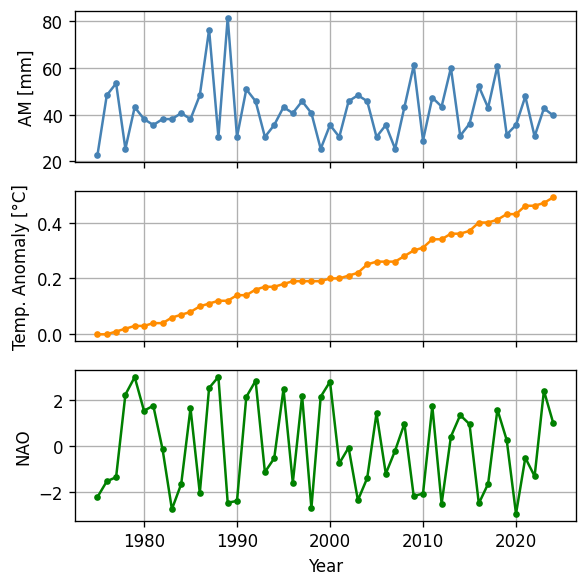

In [4]:
# Merge dataframes on 'year'
df = pd.merge(AMS_df, cov_df, on='year')

# Variables to plot
variables = ['60_min_maxima', 'temp_anomaly', 'NAO']
titles = ['AM [mm]', 'Temp. Anomaly [°C]', 'NAO']
colors = ['steelblue', 'darkorange', 'green']

# Plotting
fig, axs = plt.subplots(3, 1, figsize=(5, 5), sharex=True, dpi=120)
for i, var in enumerate(variables):
    axs[i].plot(df['year'], df[var], color=colors[i], marker='.')
    axs[i].set_ylabel(titles[i])
    axs[i].grid(True)
    
axs[-1].set_xlabel('Year')
plt.tight_layout()
plt.show()

#### Preparing Covariates and Time for Non-Stationary GEV Sampler

To model a non-stationary GEV distribution, we must prepare the **covariate matrix** and **time vector** in a format compatible with the sampler. This typically means:

1. **Converting covariates into a NumPy array**, ensuring they are aligned with the response variable (e.g., AMS).
2. **Centering the time variable** (e.g., years) by subtracting the mid-point of the record period. This helps reduce multicollinearity and improve MCMC convergence.

- Our record spans from 1975 to 2024. So, the mid-year is:
- mid_year = int((1975 + 2024) / 2)  =  1999
  ```python
  cov_df['year'] = cov_df['year'] - 1999
  ```

In [5]:
data = AMS_df['60_min_maxima'].values # data should be in chronological order
cov_df['year'] = cov_df['year'] - 1999
cov_df.head(3)

# Here, if you mess up the time covariate by running this block multiple times,
# please load AMS and Covariates again

,year,temp_anomaly,NAO
0,-24,0.00,-2.21
1,-23,0.00,-1.53
2,-22,0.01,-1.35


In [6]:
# Transposing the covariate as per the need of sampler
cov = cov_df.values.T
cov.shape

(3, 50)

#### Estimating the stationary GEV parameters 
In the following block, we estimate the stationary Generalized Extreme Value (GEV) parameters. This serves two key purposes:
- To obtain a realistic initial guess for the non-stationary model parameters.
- To define appropriate prior distributions for Bayesian estimation.

In [7]:
shape, loc, scale = ns.EVD_parsViaMLE(data,genextreme)
print(f"Shape : {shape}, Loc : {loc}, Scale : {scale}")

Shape : -0.01450631540755153, Loc : 36.210492227397154, Scale : 9.047095267044186


#### Setting up the Non-Stationary GEV Sampler
We now configure the non-stationary GEV model by specifying which parameters are modeled as functions of covariates. This is done using a config list:
```python
config = [1, 0, 0]
```
means:

- Location (μ) is a linear function of one covariate (intercept + 1 covariates, i.e., time)
- Scale (σ) is constant (no covariate dependency)
- Shape (ξ) is constant (no covariate dependency)

We also define the prior distributions for each parameter, which guide the Bayesian estimation:
- Normal priors for regression coefficients of location.
- Normal prior for the scale centered around the stationary estimate.
- Normal prior for the shape parameter centered around the stationary estimate.
Then, we initialize the NonStationaryEVD sampler using this configuration.

In [8]:
config = [1, 0, 0]
# Prior: normal for regression coefficients, uniform for scale, normal for shape
prior_specs = [
    ('normal', {'loc': loc, 'scale':loc*0.5 }),  # B0 
    ('normal', {'loc': 0, 'scale': 0.05}),  # B1
    ('normal', {'loc': scale, 'scale': scale*0.5}),   # sigma
     ('normal', {'loc': shape, 'scale': 0.3})  # xi
]
sampler = ns.NonStationaryEVD(config, data, cov,dist=genextreme,
                                  prior_specs=prior_specs)
print(sampler.descriptions) # descriptions of the GEV parameters that sampler is going to sample/estimate 

['B0 (location intercept)', 'B1 (location slope for covariate 1)', 'sigma (scale)', 'xi (shape)']


In [9]:
initial_params = [loc,0,scale,shape]
# initial_params = estimates # obtained from frequentist approach
samples,a_rate = sampler.MH_RandWalk(
    num_samples=25000, 
    initial_params=initial_params,
    proposal_widths=[0.1,0.001,0.1,1e-2],
    T=0.005
)


In [10]:
print(f"acceptance_rate : {a_rate}")
np.set_printoptions(suppress=True, precision=6)
print(f"Sample mean : {samples.mean(axis=0)}")

acceptance_rate : 0.31228
Sample mean : [36.178138  0.018966  8.985766 -0.020995]


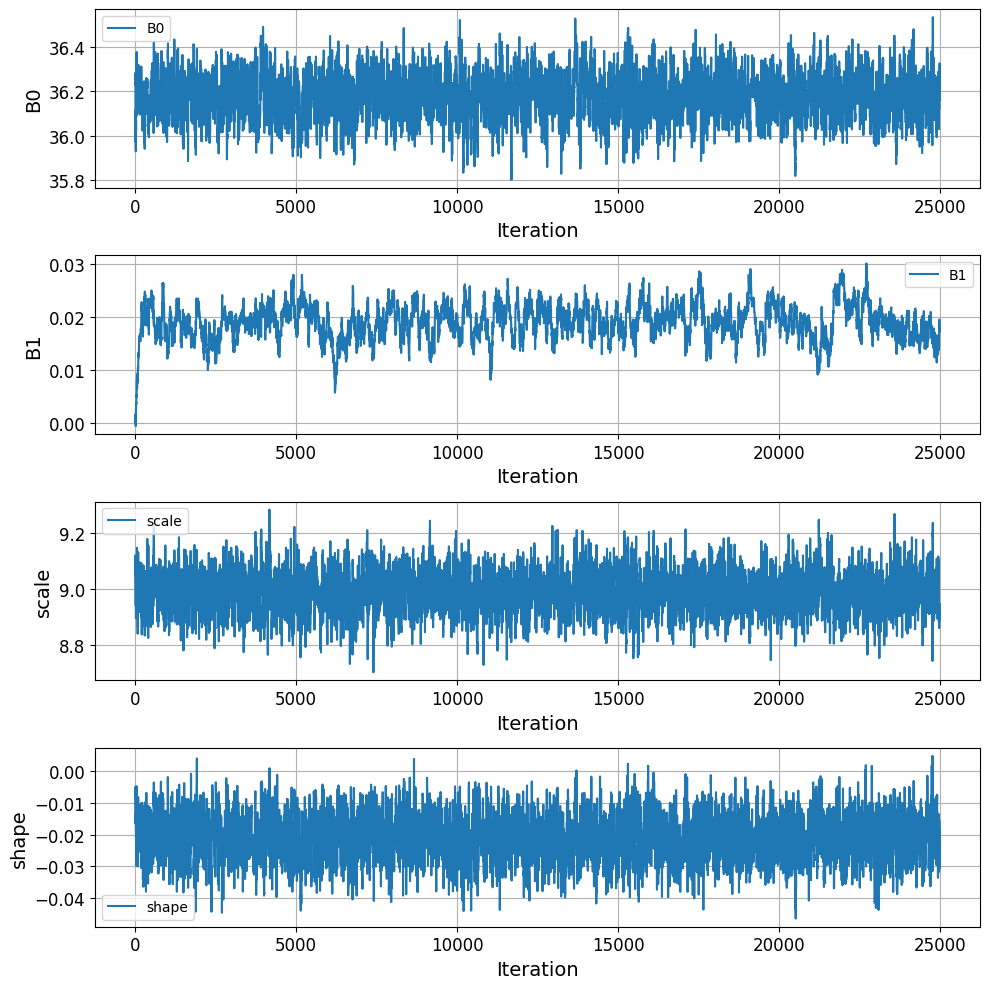

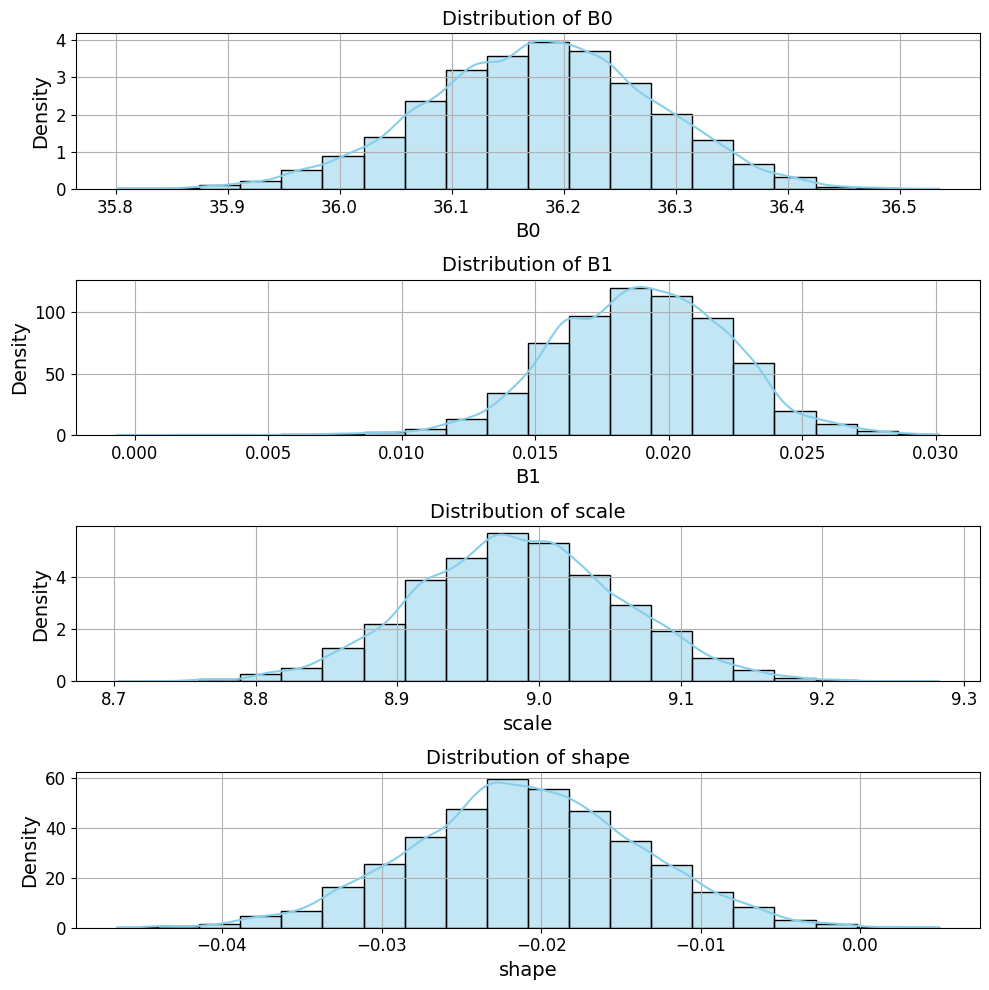

In [11]:
ns.plot_trace(samples, config,fig_size=(10,10))
ns.plot_posterior(samples, config,fig_size=(10,10))

#### Bayesian metrics and interpretation of AIC and BIC
AIC, BIC, and DIC are information criteria used to compare models by balancing goodness-of-fit and model complexity.
- Lower AIC and BIC values indicate a better balance between model fit and complexity.
- Among competing models (non-stationary vs stationary), the one with the smallest AIC, BIC, or DIC is generally preferred.
- These criteria penalize extra parameters to avoid overfitting.

In [12]:
# AIC BIC DIC test for bayesian approach
metrics  = ns.bayesian_metrics(samples, data, cov, config, dist=genextreme)
metrics

{'DIC': np.float64(378.6005901386571),
 'AIC': np.float64(386.28004147714984),
 'BIC': np.float64(393.9281334988624)}

In [13]:
# AIC abd BIC for stationary model
dist = genextreme
st_params = ns.EVD_parsViaMLE(data,dist)[[1,2,0]]
ll_st = -ns.neg_log_likelihood(st_params,data,dist)
k_st = 3
n = len(data)
aic_st = 2 * k_st - 2 * ll_st
bic_st = k_st * np.log(n) - 2 * ll_st
print(f"AIC: {aic_st:.2f}")
print(f"BIC: {bic_st:.2f}")

AIC: 384.75
BIC: 390.49


In [16]:
# help(ns.bayesian_metrics)